In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
# data dir

data_dir = 'D:/thon/project/tourism/2022년/카드데이터'

# data load

card = pd.read_csv(data_dir + '/card_sports.csv') # load하는데 12초 소요
card = card.drop(['Unnamed: 0', 'gb3', 'v3'], axis = 1) # 스포츠활동 대분류인 gb3 칼럼과, 세부지역인 v3 칼럼은 제거
card['avg_spend'] = round(card['vlm'] / card['usec'], -1).astype(int)
index_to_drop = card.loc[(card['gb2'] == '스포츠용품구매') |
(card['gb2'] == '운동경기관람')].index
card = card.drop(index_to_drop, axis = 0)


## 추천시스템화

In [44]:
### 평균소비액 이상치 제거
# 평균소비액의 이상치 판단
q1, q3 = card['avg_spend'].quantile([0.25, 0.75])
iqr = q3 - q1
df = card.loc[card['avg_spend'] < q3 + 1.5 * iqr]
index_to_drop = df.loc[df['vlm'] == 0].index
df = df.drop(index_to_drop, axis = 0)

### 쓰지 않는 칼럼 제거
df.drop(['v2','ta_ym', 'daw_ccd_r', 'apv_ts_dl_tm_r', 'avg_spend'], axis = 1, inplace = True)

### 행 병합
# 나이, 성별, 거주지, 종목명 별로 병합
new_df = df.groupby(['v1', 'sex_ccd', 'cln_age_r', 'gb2']).sum()
new_df = new_df.reset_index() # 멀티인덱스 해제
new_df['avg_spend'] = round(new_df['vlm'] / new_df['usec'], -1).astype(int) # 건당 평균취급액 칼럼 추가
new_df['cln_age_r'] = new_df['cln_age_r'].astype(str)
new_df['as_person'] = new_df['v1'] + new_df['sex_ccd'] + new_df['cln_age_r']

### 새로운 칼럼 'rating' 생성
# new_df['avg_spend'] 5개 구간으로 나눠서 레이팅 지표로 삼기
bins = pd.cut(new_df['avg_spend'], 5, labels = ['1', '2', '3', '4', '5'])
new_df['rating'] = bins

### SVD에 사용할 칼럼만 다시 추출
recommend_df = new_df[['as_person', 'gb2', 'rating']]
recommend_df.columns = ['userId', 'sportsId', 'rating']
recommend_df['rating'].astype(int)

### 추천시스템 데이터셋
from surprise import Reader, Dataset # SVD model의 dataset
from surprise.model_selection import train_test_split

# 추천 시스템 패키지에 맞는 데이터프레임 생성 (Surprise에서 제시한 데이터 구조를 따라야함)
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(recommend_df[[
    'userId', 'sportsId', 'rating']], reader = reader)

trainset, testset = train_test_split(data, test_size = .25, random_state = 12)

In [45]:
recommend_df

,userId,sportsId,rating
0,강원F20,골프,2
1,강원F20,레저스포츠,1
2,강원F20,스키,2
3,강원F20,자전거,1
4,강원F20,헬스,4
...,...,...,...
845,충북M60,골프,4
846,충북M60,레저스포츠,1
847,충북M60,스키,2
848,충북M60,자전거,4


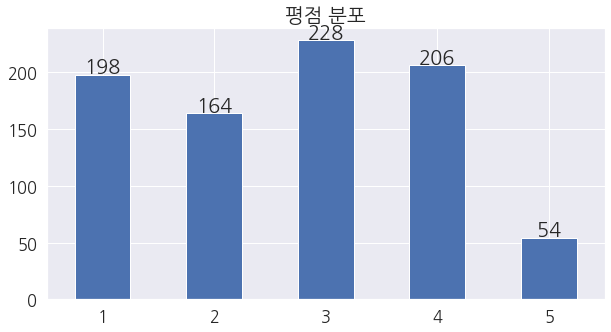

In [46]:
rating_graph = recommend_df['rating'].value_counts().sort_index()

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (10, 5))
ax = rating_graph.plot(kind = 'bar')
plt.xticks(rotation = 0)
ax.set_title('평점 분포', fontsize = 20)
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 2, height, ha = 'center', size = 20)

ax.set_xlabel('');  # semicolon suppresses text output

In [136]:
### 그리드서치로 SVD 모형의 최적의 파라미터 찾기
from surprise import SVD, accuracy # SVD model, 평가
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [25, 50, 75, 100],
'lr_all': np.linspace(0.01, 0.1, 10), 
'reg_all': np.linspace(0.01, 0.1, 10)}
gs = GridSearchCV(SVD, measures = ['RMSE'], param_grid = param_grid)
gs.fit(data)

print('Best RMSE Score: ', gs.best_score['rmse'])
print('Best Parameters: ', gs.best_params['rmse'])

Best RMSE Score:  0.7693038295619763
Best Parameters:  {'n_factors': 50, 'lr_all': 0.1, 'reg_all': 0.020000000000000004}


In [145]:
### SVD 모델 적용하여 predict
from surprise import accuracy
model = SVD(n_factors = 50, lr_all = 0.1, reg_all = 0.02)
model.fit(trainset)
predictions = model.test(testset)
print('SVD RMSE:', accuracy.rmse(predictions))

RMSE: 0.7575
SVD RMSE: 0.7574913511318275


In [175]:
### 특정 집단 특성에 대한 추천 예시
# 예: 서울에 사는 20대 남성에게 가장 추천하는 스포츠는?

ex_id = '울산M40'
if ex_id[2:3] == 'F':
    gen = '여성'
else:
    gen = '남성'

sports = ['골프', '레저스포츠', '스키', '자전거', '헬스']
ex_rating = []
print('<SVD 모형이', ex_id[:2], '에 사는', ex_id[-2:], '대', gen, '에게 추천하는 종목>')
for i, col in enumerate(sports):
    exp_rating = round(model.predict(ex_id, col).est, 1)
    ex_rating.append(exp_rating)
    print(col, '에 대한 예상 평점:', round(model.predict(ex_id, col).est, 1))

print('\n가장 추천하는 운동 종목은', sports[ex_rating.index(max(ex_rating))], ', 그 평점은', max(ex_rating), '로 예상됩니다.')
print('\n<실제 평점>')
recommend_df.loc[recommend_df['userId'] == ex_id]

<SVD 모형이 울산 에 사는 40 대 남성 에게 추천하는 종목>
골프 에 대한 예상 평점: 3.9
레저스포츠 에 대한 예상 평점: 1.0
스키 에 대한 예상 평점: 2.9
자전거 에 대한 예상 평점: 2.1
헬스 에 대한 예상 평점: 3.6

가장 추천하는 운동 종목은 골프 , 그 평점은 3.9 로 예상됩니다.

<실제 평점>


,userId,sportsId,rating
535,울산M40,골프,4
536,울산M40,레저스포츠,1
537,울산M40,스키,3
538,울산M40,자전거,2
539,울산M40,헬스,3


## KNNBaseline

In [144]:
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV

param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': range(15, 40),
              'verbose': [False],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [True]}
              }
gs = GridSearchCV(KNNBaseline, param_grid, measures = ['rmse', 'mae'], cv = 7)

gs.fit(data)
print('Best RMSE Score: ', gs.best_score['rmse'])
print(gs.best_params['rmse'])

Best RMSE Score:  0.7352993920289499
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 28, 'verbose': False, 'sim_options': {'name': 'pearson_baseline', 'min_support': 1, 'user_based': True}}


In [146]:
algo = KNNBaseline(
    sim_options = {'name': 'pearson_baseline', 'min_support': 1, 'user_based':[True]},
    k = 28,
    bsl_options = {'method': 'als', 'reg': 1},
    verbose = False)

algo.fit(trainset)
predictions = algo.test(testset)
print('KNNBaseline RMSE:', accuracy.rmse(predictions))

RMSE: 0.7191
0.7190972607150229


In [159]:
predictions

[Prediction(uid='제주F50', iid='자전거', r_ui=3.0, est=3.291463584326909, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='인천M40', iid='자전거', r_ui=4.0, est=3.1428327546319474, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='울산M50', iid='헬스', r_ui=3.0, est=3.2993960511358496, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='경북M30', iid='레저스포츠', r_ui=1.0, est=1.120732198336216, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='서울F30', iid='스키', r_ui=2.0, est=2.2441882136893647, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='강원M30', iid='골프', r_ui=2.0, est=3.3775812016680846, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='서울F40', iid='골프', r_ui=5.0, est=3.8020964521972846, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='울산F40', iid='레저스포츠', r_ui=1.0, est=1.0542702119862766, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='전북F40', ii

In [177]:
### 특정 집단 특성에 대한 추천 예시
# 예: 서울에 사는 30대 남성에게 가장 추천하는 스포츠는?

ex_id = '제주F40'

if ex_id[2:3] == 'F':
    gen = '여성'
else:
    gen = '남성'

sports = ['골프', '레저스포츠', '스키', '자전거', '헬스']
ex_rating = []
print('<KNNBaseline 모형이', ex_id[:2], '에 사는', ex_id[-2:], '대', gen, '에게 추천하는 종목>')

for i, col in enumerate(sports):
    exp_rating = round(algo.predict(uid = ex_id, iid = col).est, 1)
    ex_rating.append(exp_rating)
    print(col, '에 대한 예상 평점:', round(algo.predict(uid = ex_id, iid = col).est, 1))

print('\n가장 추천하는 운동 종목은', sports[ex_rating.index(max(ex_rating))], ', 그 평점은', max(ex_rating), '로 예상됩니다.')

print('\n<실제 평점>')
recommend_df.loc[recommend_df['userId'] == ex_id]

<KNNBaseline 모형이 제주 에 사는 40 대 여성 에게 추천하는 종목>
골프 에 대한 예상 평점: 4.8
레저스포츠 에 대한 예상 평점: 1.8
스키 에 대한 예상 평점: 2.9
자전거 에 대한 예상 평점: 3.0
헬스 에 대한 예상 평점: 4.0

가장 추천하는 운동 종목은 골프 , 그 평점은 4.8 로 예상됩니다.

<실제 평점>


,userId,sportsId,rating
710,제주F40,골프,5
711,제주F40,레저스포츠,2
712,제주F40,스키,3
713,제주F40,자전거,3
714,제주F40,헬스,4
